# Face Recognition System

> __The system is designed in a way the you can train a model on multiple faces and can register each face with a name and id. Hence forth system can later be used to recognize multiple faces at a time.__

![FR_gif](https://i.pinimg.com/originals/2e/16/a8/2e16a81155d82049a213a3bc0c7ce1bc.gif)

## Dependencies:-
1. os :- for navigation through directories and file saving purposes\
2. cv2 :- for computer vision and machine learning
3. numpy:- to handle encoded image data inform of arrays
4. PIL.image :- handling images for opening, manipulating, saving
5. pickle :- file handling for saving names corresponding to face

In [ ]:
# install dependencies:-
!pip uninstall opencv-python
!pip install opencv-contrib-python
!pip install Pillow

#!pip install opencv-contrib-python --upgrade  if you are faci9ng module import errors!!.

In [1]:
import cv2
import numpy as np
from PIL import Image 
import pickle
import os

## Please make the directories for storing sample face images "dataset" in the root folder and "trainer" directory for storing model.

In [ ]:
# creating pickle file for name list.
'''DO NOT RUN THESE LINES TWICE'''

names = []
filename = "names.pkl"
f = open(filename, 'wb')
pickle.dump(names,f)
f.close()

# Face Registration
---
## Face Sampling

Used __Haarcascade__ for detecting facial features and detecting a face. [Link to download](http://alereimondo.no-ip.org/OpenCV/uploads/34/frontalFace10.zip) 

[Github](https://github.com/RitvikDayal/Face-Recognition-LPBH)

__Reason__ :- Its is efficient and fast method with high accuracy.

In [2]:
def faceSampling():
    cam = cv2.VideoCapture('http://192.168.43.1:8080/video')
    cam.set(3, 640) # set video width
    cam.set(4, 480) # set video height

    face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    with open('names.pkl', 'rb') as f:
        names = pickle.load(f)

    name = input('Enter name for the Face: ')
    names.append(name)
    id = names.index(name)

    print('''\n
    Look in the camera Face Sampling has started!.
    Try to move your face and change expression for better face memory registration.\n
    ''')
    # Initialize individual sampling face count
    count = 0

    while(True):

        ret, img = cam.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(gray, 1.3, 5)

        for (x,y,w,h) in faces:

            cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)     
            count += 1

            # Save the captured image into the datasets folder
            cv2.imwrite("dataset/"+name+"." + str(id) + '.' + str(count) + ".jpg", gray[y:y+h,x:x+w])

            cv2.imshow('image', img)

        k = cv2.waitKey(100) & 0xff # Press 'ESC' for exiting video
        if k == 27:
            break
        elif count >= 80: # Take 80 face sample and stop video
             break

    with open('names.pkl', 'wb') as f:
        pickle.dump(names, f)

    # Do a bit of cleanup
    print("Your Face has been registered as {}\n\nExiting Sampling Program".format(name.upper()))
    cam.release()
    cv2.destroyAllWindows()

## Face Training

Used LBPH Algorithm from opencv library for training and modelling purpose to avoid illumination differences in image.

The below function gets all the sample images and then filter them on face id bases and train the model using LBPH.

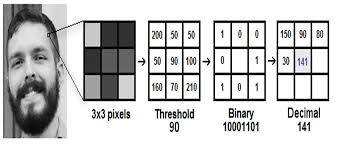

In [3]:
def faceLearning():
    # Path for face image database
    path = 'dataset'

    recognizer = cv2.face.LBPHFaceRecognizer_create() 
    detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    # function to get the images and label data
    def getImagesAndLabels(path):

        imagePaths = [os.path.join(path,f) for f in os.listdir(path)]     
        faceSamples=[]
        ids = []

        for imagePath in imagePaths:

            PIL_img = Image.open(imagePath).convert('L') # convert it to grayscale
            img_numpy = np.array(PIL_img,'uint8')

            id = int(os.path.split(imagePath)[-1].split(".")[1])
            faces = detector.detectMultiScale(img_numpy)

            for (x,y,w,h) in faces:
                faceSamples.append(img_numpy[y:y+h,x:x+w])
                ids.append(id)

        return faceSamples,ids

    print ("\nTraining for the faces has been started. It might take a while.\n")
    faces,ids = getImagesAndLabels(path)
    recognizer.train(faces, np.array(ids))

    # Save the model into trainer/trainer.yml
    recognizer.write('trainer/trainer.yml') 

    # Print the numer of faces trained and end program
    print("{0} faces trained. Exiting Training Program".format(len(np.unique(ids))))    

### Face Recognition

In [4]:
def faceRecognition():
    print('\nStarting Recognizer....')
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    recognizer.read('trainer/trainer.yml')
    cascadePath = "haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascadePath);

    font = cv2.FONT_HERSHEY_SIMPLEX

    # Starting realtime video capture
    cam = cv2.VideoCapture('http://192.168.43.1:8080/video')
    cam.set(3, 640) # set video widht
    cam.set(4, 480) # set video height

    # Define min window size to be recognized as a face
    minW = 0.1*cam.get(3)
    minH = 0.1*cam.get(4)

    with open('names.pkl', 'rb') as f:
        names = pickle.load(f)

    while True:

        ret, img =cam.read()

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        faces = faceCascade.detectMultiScale( 
            gray,
            scaleFactor = 1.2,
            minNeighbors = 5,
            minSize = (int(minW), int(minH)),
           )

        for(x,y,w,h) in faces:

            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            id, confidence = recognizer.predict(gray[y:y+h,x:x+w])

            # Check if confidence is less them 100 ==> "0" is perfect match 
            if (confidence < 100):
                id = names[id]
                confidence = "  {0}%".format(round(100 - confidence))
            else:
                id = "unknown"
                confidence = "  {0}%".format(round(100 - confidence))

            cv2.putText(img, str(id), (x+5,y-5), font, 1, (255,255,255), 2)
            cv2.putText(img, str(confidence), (x+5,y+h-5), font, 1, (255,255,0), 1)  

        cv2.imshow('camera',img) 

        k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
        if k == 27:
            break

    # Do a bit of cleanup
    print("\nExiting Recognizer.")
    cam.release()
    cv2.destroyAllWindows()

In [5]:
def main():
    while True:
        choice = int(input('''
        ###################################################################
        1 --> Register New Face.
        2 --> Face Recognization.
        3 --> Exit.
        Your Choice: 
        '''))
        
        if choice == 1:
            faceSampling()
            faceLearning()
        elif choice == 2:
            faceRecognition()
        elif choice == 3:
            print('\nExiting Program.')
            break

In [6]:
main()


        ###################################################################
        1 --> Register New Face.
        2 --> Face Recognization.
        3 --> Exit.
        Your Choice: 
        2

Starting Recognizer....

Exiting Recognizer.

        ###################################################################
        1 --> Register New Face.
        2 --> Face Recognization.
        3 --> Exit.
        Your Choice: 
        3

Exiting Program.


### Note:-
> Did not used global variables as using a single variable for multiple functions during same run will results in errors as in reading and writting files and models.